### Advanced Lane Lines Project

The goals of this project is to create a pipleline to identify the lane boundaries in a video from a front-facing camera on a car.  

The steps are the following:
1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms and gradients to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from moviepy.editor import VideoFileClip
from moviepy.editor import CompositeVideoClip
from IPython.display import HTML
import pickle
import glob
%matplotlib inline

### Step 1 and 2 
#### Calcuate Camera Calibration Matrix and Distortion Coefficients and apply distortion correction to raw images

#### I use images in the camera_cal directory to calculate the camera matrix and distortion coefficients. I then use the distortion coefficients to undistort the test image. The code is taken from the sample code in the course with some modifications. 

In [23]:
# Camera Calibration
def calibrate_camera (path, nx, ny):
    
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane
    
    #prepare object points
    objp = np.zeros([ny*nx,3],np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates of corner points
    
    images = glob.glob(path)
    
    for fname in images:
        img = mpimg.imread(fname)
        gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
        
         # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        # If found, draw corners
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

    img = mpimg.imread('camera_cal/calibration1.jpg')
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    return mtx,dist

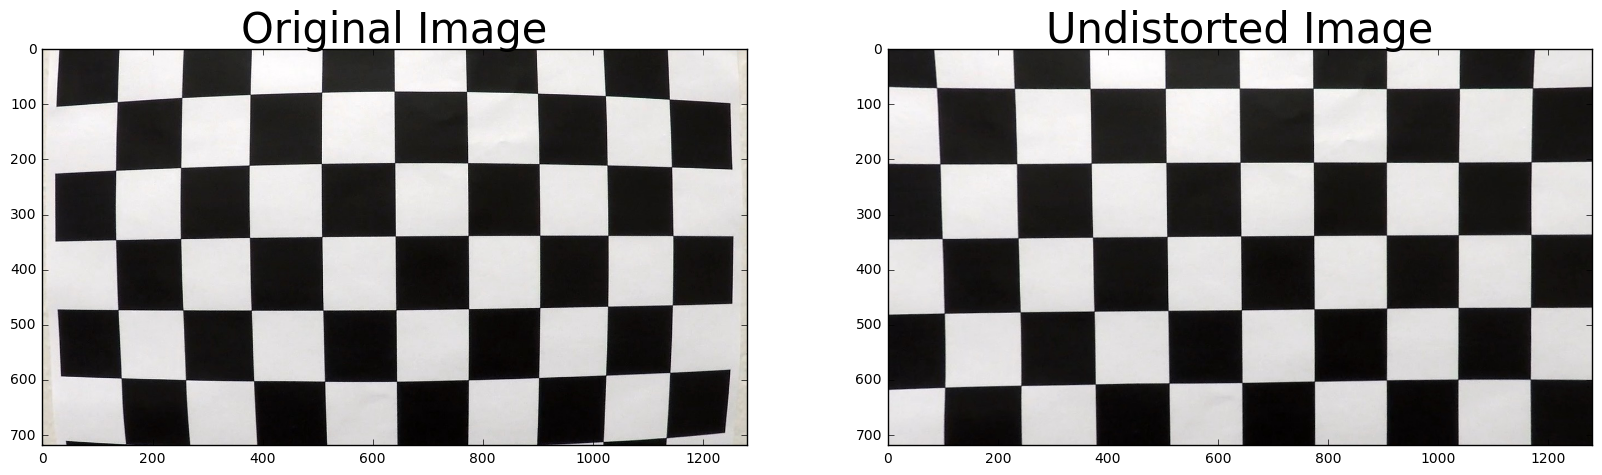

In [24]:
# Step 1. Calibrate the camera using the calibration images
nx = 9
ny = 6
mtx,dist = calibrate_camera('camera_cal/calibration*.jpg',nx, ny)

fname = 'camera_cal/calibration1.jpg'
img = mpimg.imread(fname)

# Step 2. Undistortation to the raw image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )

mpimg.imsave('output_images/calibrated1_undistorted.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


### Step 3 

#### Use color transforms and gradients to create a thresholded binary image.

#### HLS color transform was used.  Saturation and lightness channel threshold were both applied.  Lightness channel threshold was applied in order to work around the shadow issue

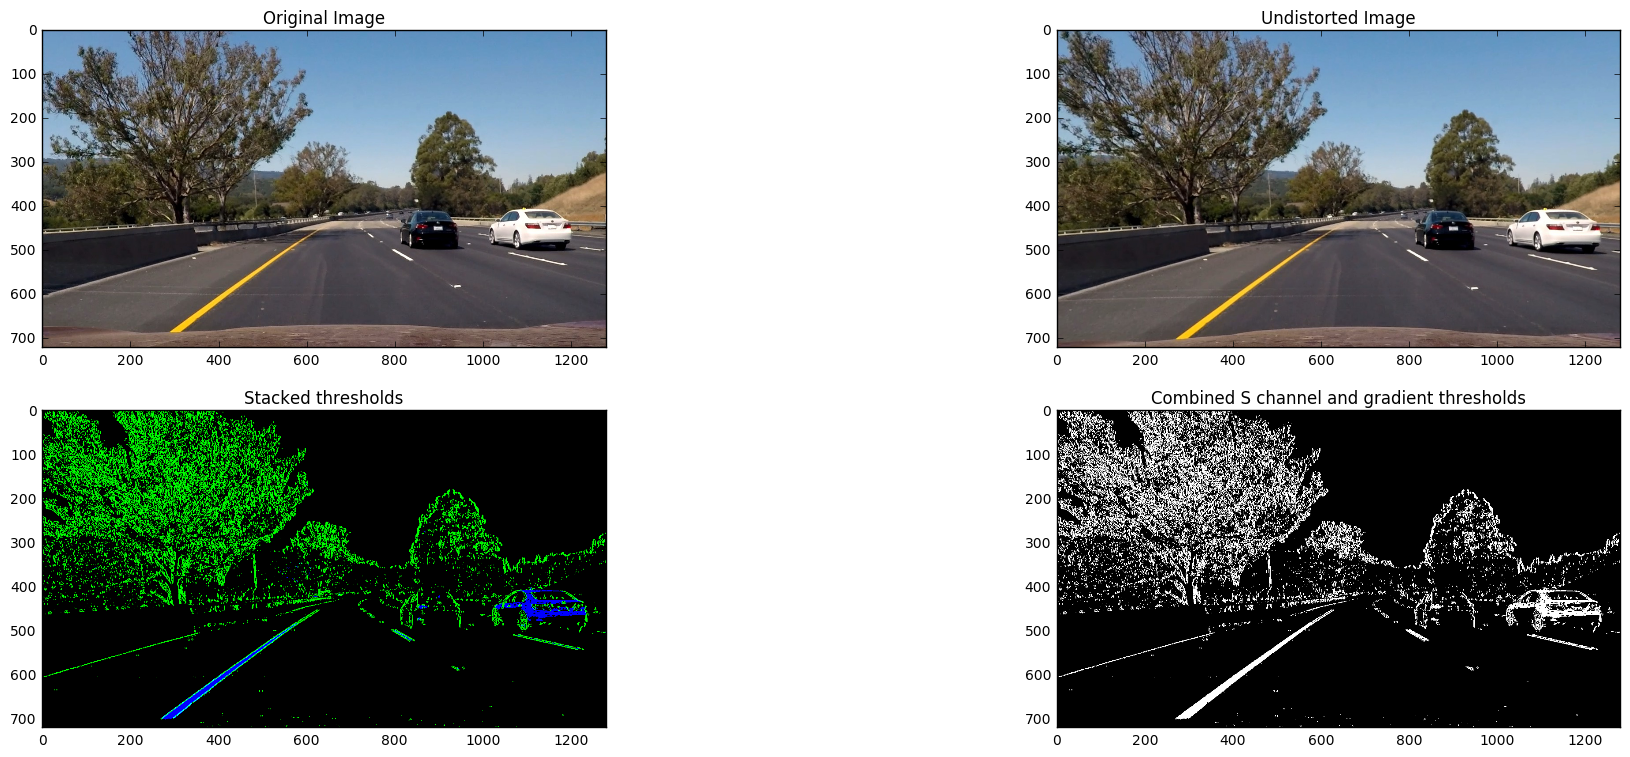

In [33]:
# Yellow and white color threshold
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

img = mpimg.imread('test_images/test6.jpg')
undistorted_im = cv2.undistort(img, mtx, dist, None, mtx)

def threshold_img(img, s_thresh=(170, 255), sx_thresh=(20, 100),  l_thresh = (30, 255)):
    
    img = np.copy(img)
    
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    
    # Threshold color channel saturation and lightness channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) 
             & (l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return color_binary, combined_binary

color_binary, combined_binary = threshold_img(undistorted_im)

# Plot the orig and result    
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24,9)) 
#f.tight_layout()
    
ax1.imshow(img)
ax1.set_title('Original Image')
 
ax2.imshow(undistorted_im)
ax2.set_title('Undistorted Image')

ax3.imshow(color_binary)   
ax3.set_title('Stacked thresholds')

ax4.imshow(combined_binary, cmap='gray')
ax4.set_title('Combined S channel and gradient thresholds')


###  Step 4 Perspective Transform
#### Apply perspective transfer to the image to generate a "Birds-eye view" of the lane markers.

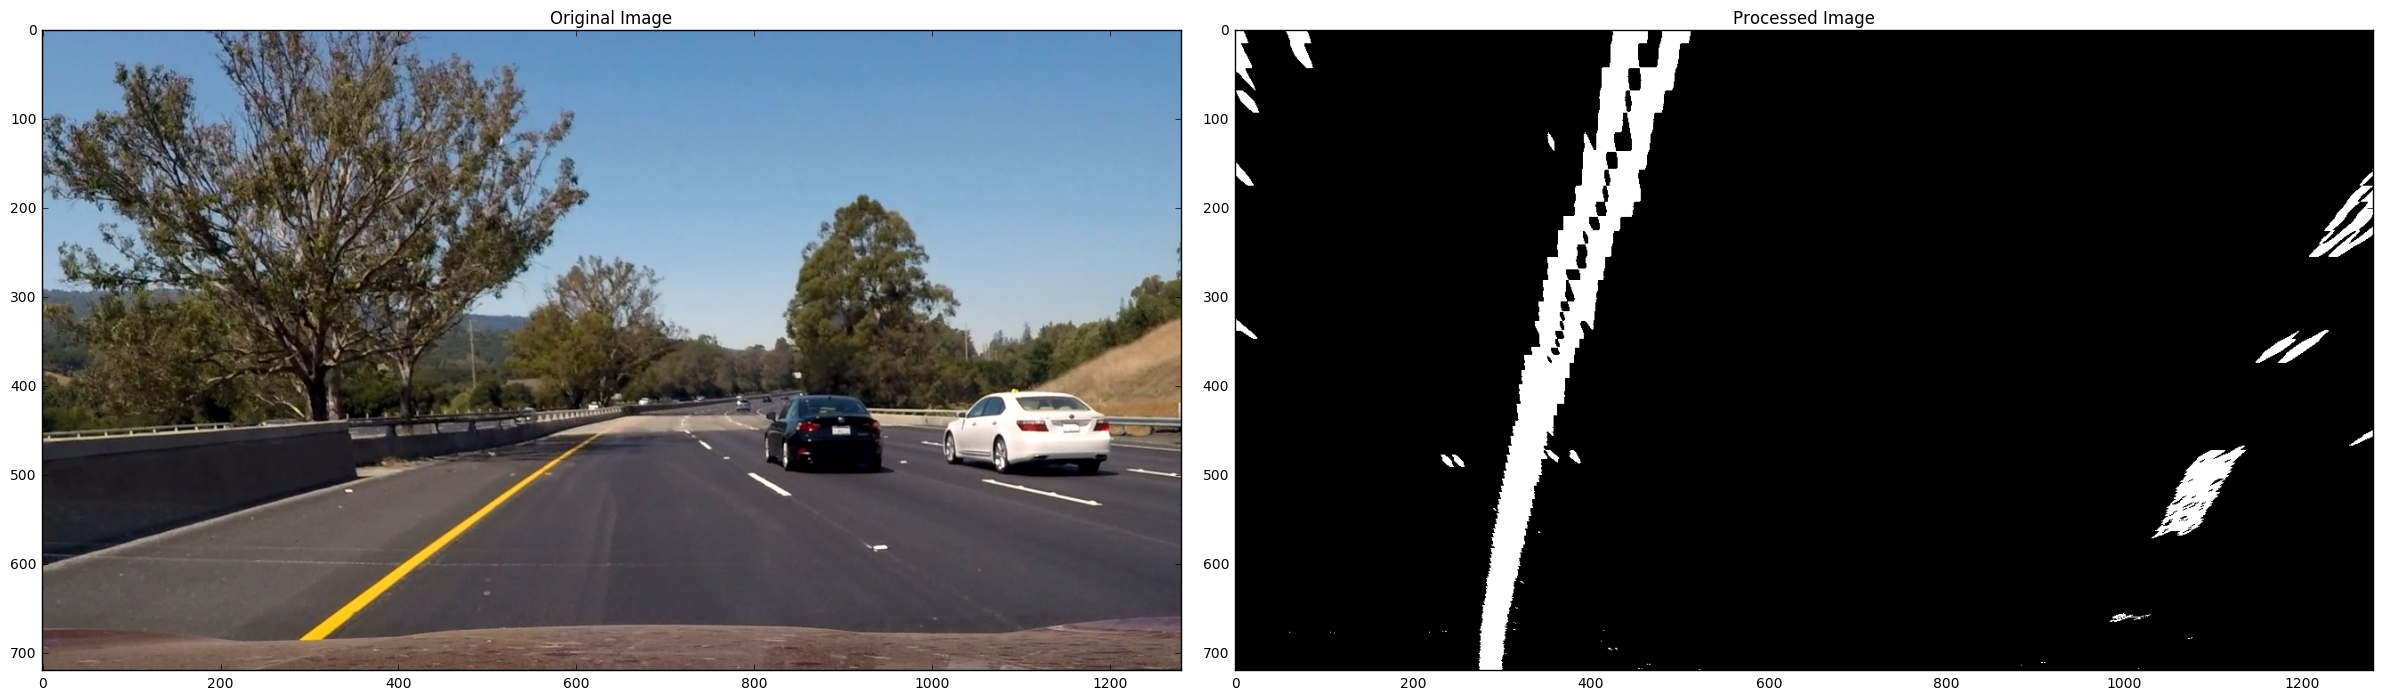

In [34]:
offset = 300
img_size = (img.shape[1], img.shape[0])

src = np.float32([[595,460],[680, 460],[1150, 700],[300,700]])
dst = np.float32([[offset, 0], [img_size[0]-offset,0],[img_size[0]-offset, img_size[1]], [offset,img_size[1]]])   
M = cv2.getPerspectiveTransform(src,dst)
Minv =  cv2.getPerspectiveTransform(dst,src)

def warp (img):
    
    warped = cv2.warpPerspective(img,M,img_size)
    
    return warped

warp_image = warp(combined_binary)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image')

ax2.imshow(warp_image,cmap='gray')
ax2.set_title('Processed Image')



### Step 5 Detect lane pixels and fit to find the lane boundary.

#### 5 (a) Determine which pixels are part of the left and right line. I used "peaks in histogram" line finding method as described in the course.  First, take a historgram along all the colums in the lower half of the image. Then, a sliding window was used to plac around the line center, t find and follow the lines up to the top of the frame.

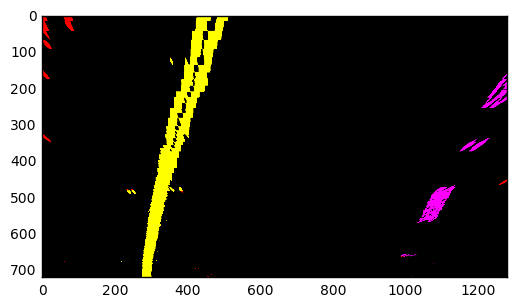

In [35]:
histogram = np.sum(warp_image[int(warp_image.shape[0]/2):,:], axis=0)

def lane_center(h):
    mid = np.int(h.shape[0]/2)
    left = np.argmax(h[0:mid]) 
    right = np.argmax(h[mid:])+mid
    return left, right

def lane_samples(bw_img, mid, win_size= 80):
    line = np.zeros_like(bw_img)
    for row in range(bw_img.shape[0]-1, 0, -1):
        
        lo = max(0, mid-win_size)
        hi = min(mid+win_size, bw_img.shape[1]-1)

        scan_line =bw_img[row,lo:hi]
        line[row,lo:hi] = scan_line
        ones = np.where(scan_line == 1)
       
        if len(ones[0]):
            mid = np.int(np.mean(ones)+lo+0.5)
    return line
    
def identify_line(bw_image):
    histogram = np.sum(bw_image[int(bw_image.shape[0]/2):,:], axis=0)
    ml, mr=lane_center(histogram)
    return lane_samples(bw_image, ml), lane_samples(bw_image,mr)
    
left_line, right_line = identify_line(warp_image)   
line_image= np.dstack((warp_image,left_line,right_line))
line_image=line_image.astype(float) 
plt.imshow(line_image)  



#### 5 (b) After finding the lane pixels are identified, now fit them to a 2nd order polynomial as well Step 6 : determine the curvature of the lane and vehicle position with respect to center.

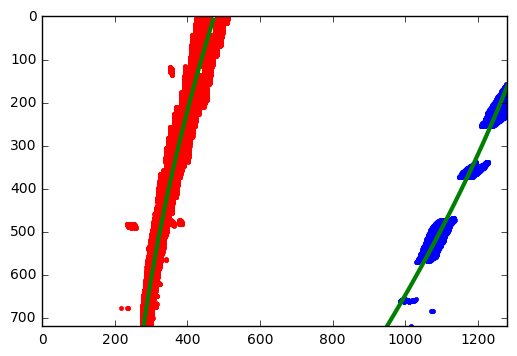

In [42]:
#circularbuffer to keep track of recent measurements

from collections import deque
class CircularBuffer(deque):
    def __init__(self, size = 0):
            super(CircularBuffer, self).__init__(maxlen = size)
    @property
    def average(self):
        return sum(self)/len(self)
            
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #polynomial coefficients for the most recent fit
        self.current_fit = None
        
        #polynomial coefficients for the recent fits
        self.recent_fits = CircularBuffer(15)
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = CircularBuffer(15)
        
        #average radius of curvature over the last n iterations
        self.avg_radius_of_curvature = None
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = CircularBuffer(15) 
        
        #average distance in meters of vehicle center from the line
        self.avg_line_base_pos = None
        
        #x values for detected line pixels
        self.allx = None  
       
    #append the most recent measurement to the buffer if the measurement is in a valid range
    def update(self,line):
        if line.avg_radius_of_curvature > 300: 
            self.recent_fits.append(line.current_fit)
            self.radius_of_curvature.append(line.avg_radius_of_curvature)
            self.line_base_pos.append(line.avg_line_base_pos)
            self.current_fit = line.current_fit
        
    def getAvgCurverad(self):
        self.avg_radius_of_curvature = self.radius_of_curvature.average
        return self.avg_radius_of_curvature
    
    def getAvgLineBasePos(self):
        self.avg_line_base_pos = self.line_base_pos.average
        return self.avg_line_base_pos
    
    def getBestFit(self):
        return self.recent_fits.average
    
    def getAllX(self, yvals):
        best_fit = self.getBestFit()
        self.allx = best_fit[0]*yvals**2 + best_fit[1] * yvals + best_fit[2]
        return self.allx
        
#calculate lane polynomials and radius of curvature
def find_lane_polynomials(img):
   
    left_line_sample, right_line_sample = identify_line(img)   
    
    #get the indices of non zero elements
    left_indicies = np.transpose(np.nonzero(left_line_sample)) 
    right_indicies = np.transpose(np.nonzero(right_line_sample))
    
    #left lane samples
    leftx = left_indicies[:,1]
    lefty = left_indicies[:,0]
        
    #right lane samples
    rightx = right_indicies[:,1]
    righty = right_indicies[:,0]
    
    left_line= Line()
    right_line =Line()
    
    yvals = np.linspace(1,100,num=101)*7.2
    
    #fit left and right lane marker samples to 2nd order polynomial
    left_line.current_fit = np.polyfit(lefty,leftx, 2)
    left_line.allx = left_line.current_fit[0]*yvals**2 + left_line.current_fit[1]*yvals \
                      + left_line.current_fit[2]
    right_line.current_fit = np.polyfit(righty, rightx, 2)
    right_line.allx = right_line.current_fit[0]*yvals**2 + right_line.current_fit[1]*yvals \
                      + right_line.current_fit[2]
    
    #plot the lane marker
    debug =1
    if debug:
        plt.plot(leftx,lefty,'.',color='red')
        plt.plot(rightx,righty,'.',color='blue')
        plt.plot(left_line.allx, yvals, color='green', linewidth=3)
        plt.plot(right_line.allx, yvals, color='green', linewidth=3)
        plt.xlim(0, 1280)
        plt.ylim(0, 720)
        plt.gca().invert_yaxis() # to visualize as we do the images
    
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    
    y_eval = np.max(lefty)*ym_per_pix
   
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    #calculate curve radius for left and right
    left_line.avg_radius_of_curvature=((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
    right_line.avg_radius_of_curvature=((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
    
    #calculate vehicle position with respect to the lenter
    vehicle_pos_x = (img.shape[1] / 2) * xm_per_pix
    left_x = left_fit_cr[0]*y_eval**2 + left_fit_cr[1]*y_eval + left_fit_cr[2]
    right_x = right_fit_cr[0]*y_eval**2 + right_fit_cr[1]*y_eval + right_fit_cr[2]
  
    
    left_line.line_base_pos.append(vehicle_pos_x - left_x)
    right_line.line_base_pos.append(vehicle_pos_x - right_x)
    
        
    left_line.avg_line_base_pos = left_line.line_base_pos.average
    right_line.avg_line_base_pos = right_line.line_base_pos.average
    
    
    return left_line, right_line

left_line, right_line= find_lane_polynomials(warp_image) 


### Step 7 and 8 Warp the detected lane boundaries back onto the original image and output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

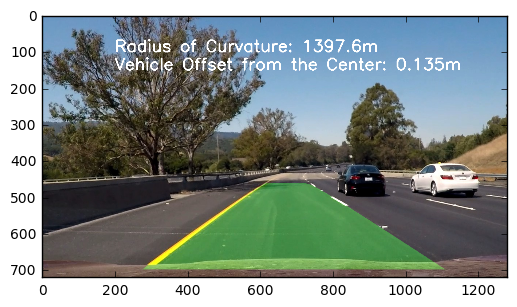

In [41]:

# Draw the lines back down onto the road
def draw_line(warped,image, left_line, right_line):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    yvals = np.linspace(1,100,num=101)*7.2
    
    left_line_marker, right_line_marker = find_lane_polynomials(warped)

    # Smooth over the measurement.  Append the lastest measure to the buffer 
    left_line.update(left_line_marker)
    right_line.update(right_line_marker)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx  = left_line.getAllX(yvals)
    right_fitx = right_line.getAllX(yvals)
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    image= cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    #add text overlay
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    image = cv2.putText(image,'Radius of Curvature: '+'{:.01f}'.format(right_line.getAvgCurverad()+left_line.getAvgCurverad()/2) + 'm',(200,100), font, 1.5,(255,255,255),4)
    image = cv2.putText(image,'Vehicle Offset from the Center: '+ '{:.03f}'.format((left_line.getAvgLineBasePos() + right_line.getAvgLineBasePos()) / 2) + 'm',(200,150), font, 1.5,(255,255,255),4)
    return image

left_line = Line()
right_line = Line()
result = draw_line(warp_image,img, left_line, right_line)
plt.imshow(result)

In [43]:
# Pipeline to process each frame

def process(img, left_line, right_line):
    
    # undistort the image
    undistorted_im = cv2.undistort(img, mtx, dist, None, mtx)
    
    #threshold the image
    color_binary, combined_binary = threshold_img(undistorted_im)
    
    #warp the image
    warp_im = warp(combined_binary)
    
    return draw_line(warp_im,img, left_line, right_line)
    


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:10<00:00,  6.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 33s, sys: 45.7 s, total: 4min 19s
Wall time: 3min 11s


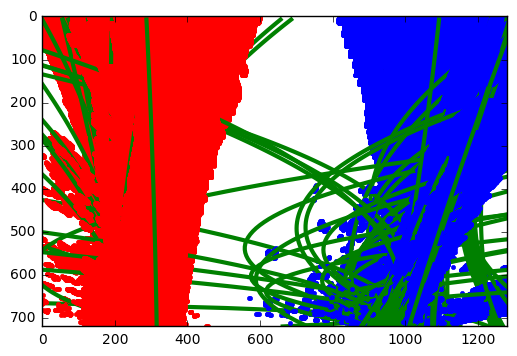

In [45]:
# Run algorithm on project video

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'project_video_output.mp4'
input_video = VideoFileClip("project_video.mp4")
left_line = Line()
right_line = Line()
process_with_frames = lambda x: process(x,left_line, right_line)
output_clip = input_video.fl_image(process_with_frames) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)